Step 0, Train Acc: 0.025, Val Acc: 0.040, Sharpness: -0.002, Time per 100 steps: 0.23s
Step 100, Train Acc: 0.062, Val Acc: 0.008, Sharpness: 0.012, Time per 100 steps: 0.22s
Step 200, Train Acc: 0.087, Val Acc: 0.000, Sharpness: 0.278, Time per 100 steps: 0.22s
Step 300, Train Acc: 0.252, Val Acc: 0.000, Sharpness: 0.650, Time per 100 steps: 0.22s
Step 400, Train Acc: 0.469, Val Acc: 0.000, Sharpness: 1.505, Time per 100 steps: 0.22s
Step 500, Train Acc: 0.719, Val Acc: 0.000, Sharpness: 1.315, Time per 100 steps: 0.22s
Step 600, Train Acc: 0.883, Val Acc: 0.000, Sharpness: 2.374, Time per 100 steps: 0.22s
Step 700, Train Acc: 0.977, Val Acc: 0.000, Sharpness: 2.189, Time per 100 steps: 0.22s
Step 800, Train Acc: 1.000, Val Acc: 0.004, Sharpness: 2.490, Time per 100 steps: 0.22s
Step 900, Train Acc: 1.000, Val Acc: 0.004, Sharpness: 3.597, Time per 100 steps: 0.22s
Step 1000, Train Acc: 1.000, Val Acc: 0.006, Sharpness: 3.723, Time per 100 steps: 0.22s
Step 1100, Train Acc: 1.000, Val

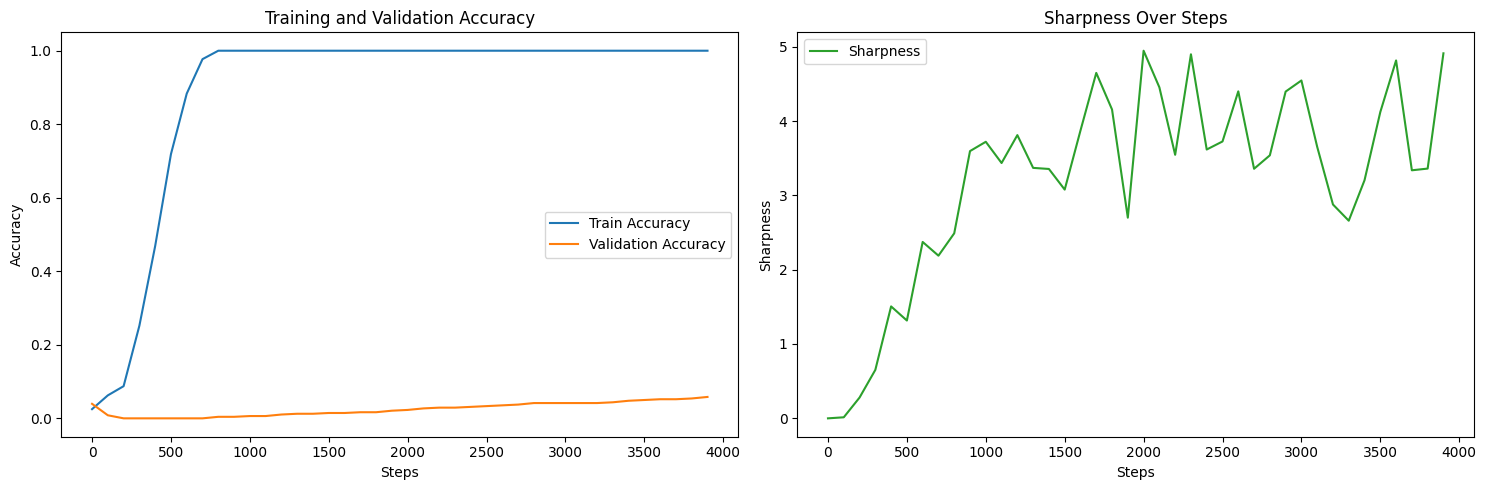

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import os
import time

# 1. Data Generation
class ModularAdditionDataset(Dataset):
    def __init__(self, p, embed_dim):
        assert embed_dim > p + 2, "Embedding dimension must be greater than p + 2"
        self.p = p
        self.embed_dim = embed_dim
        
        x = torch.arange(p)
        y = torch.arange(p)
        self.x, self.y = torch.meshgrid(x, y, indexing='ij')
        self.result = (self.x + self.y) % p
        
        # Flatten tensors
        self.x = self.x.reshape(-1)
        self.y = self.y.reshape(-1)
        self.result = self.result.reshape(-1)
        
        # Convert to one-hot vectors
        self.x = nn.functional.one_hot(self.x, self.embed_dim)
        self.y = nn.functional.one_hot(self.y, self.embed_dim)
        
        # Create one-hot vectors for '+' and '='
        self.plus = nn.functional.one_hot(torch.tensor([p]), embed_dim)
        self.equals = nn.functional.one_hot(torch.tensor([p + 1]), embed_dim)
        
    def __len__(self):
        return len(self.result)
        
    def __getitem__(self, idx):
        x_onehot = self.x[idx].float()
        y_onehot = self.y[idx].float()
        result = self.result[idx]
        # Concatenate x, +, y, =, result
        input_vector = torch.stack([x_onehot, self.plus.squeeze(0).float(), y_onehot, self.equals.squeeze(0).float()])
        
        return input_vector, result 

# 2. Transformer Model
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int):
        super().__init__()

        self.self_attn = nn.MultiheadAttention(dim_model, n_heads)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Linear(dim_model * 4, dim_model),
            nn.Dropout(0.0)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        attn_mask = torch.triu(attn_mask, diagonal=1)
        
        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.self_attn_norm(x + a1)
        a2 = self.ffn(a1)
        a2 = self.ffn_norm(a1 + a2)

        return a2

class SimpleTransformer(nn.Module):
    def __init__(self, num_layers: int, dim_model: int, num_heads: int, num_tokens: int):
        super().__init__()

        self.model = nn.Sequential(
            *[DecoderBlock(dim_model, num_heads) for _ in range(num_layers)],
            nn.LayerNorm(dim_model),
            nn.Linear(dim_model, num_tokens)
        )

    def _position_encoding(self, seq_len, dim_model):
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(dim_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / dim_model)
        angle_rads = pos * angle_rates

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return torch.tensor(pos_encoding, dtype=torch.float32)

    def forward(self, x):
        position_embedding = self._position_encoding(x.shape[1], x.shape[2]).to(x.device)
        embedding = x + position_embedding
        embedding = embedding.permute(1, 0, 2)  # (seq_len, batch_size, dim_model)
        output = self.model(embedding)
        output = output[-1, :, :]  # (batch_size, num_tokens)
        return output
    

# 3. 计算Sharpness
def compute_sharpness(model, loss_fn, data_loader, epsilon=0.01):
    """
    计算模型在某个参数位置的sharpness。
    """
    initial_params = [p.clone().detach() for p in model.parameters()]
    
    # 计算原始损失
    model.eval()  # 在测试模式下
    original_loss = 0.0
    for batch in data_loader:
        inputs = batch[0]  # 不使用 .to(device)
        labels = batch[1]  # 不使用 .to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        original_loss += loss.item()
    original_loss /= len(data_loader)
    
    # 扰动参数
    for param in model.parameters():
        param.data += epsilon * torch.randn_like(param)
    
    # 计算扰动后的损失
    perturbed_loss = 0.0
    for batch in data_loader:
        inputs = batch[0]  # 不使用 .to(device)
        labels = batch[1]  # 不使用 .to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        perturbed_loss += loss.item()
    perturbed_loss /= len(data_loader)
    
    # 恢复模型的原始参数
    for param, initial_param in zip(model.parameters(), initial_params):
        param.data = initial_param
    
    # 计算sharpness
    sharpness = perturbed_loss - original_loss
    return sharpness


# 4. Training Loop
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs, save_path, epsilon=0.01):
    train_accs = []
    val_accs = []
    sharpness_values = []  # 添加 sharpness 跟踪
    steps = []
    current_step = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        for x, labels in train_loader:
            x = x  # 不需要 .to(device)
            labels = labels  # 不需要 .to(device)

            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if current_step % 100 == 0:
                with torch.no_grad():
                    # 训练准确度
                    train_pred = outputs.argmax(dim=1)
                    train_acc = (train_pred == labels).float().mean().item()

                    # 验证准确度
                    model.eval()
                    val_correct = 0
                    val_total = 0
                    for val_x, val_labels in val_loader:
                        val_x = val_x  # 不需要 .to(device) 了
                        val_labels = val_labels  # 不需要 .to(device) 了
                        val_outputs = model(val_x)
                        val_pred = val_outputs.argmax(dim=1)
                        val_correct += (val_pred == val_labels).sum().item()
                        val_total += val_labels.size(0)
                    val_acc = val_correct / val_total
                    model.train()

                    train_accs.append(train_acc)
                    val_accs.append(val_acc)

                    # 计算 sharpness
                    sharpness = compute_sharpness(model, criterion, train_loader, epsilon)
                    sharpness_values.append(sharpness)

                    steps.append(current_step)
                    end_time = time.time()
                    step100_duration = end_time - start_time
                    start_time = end_time

                    print(f'Step {current_step}, Train Acc: {train_acc:.3f}, Val Acc: {val_acc:.3f}, Sharpness: {sharpness:.3f}, Time per 100 steps: {step100_duration:.2f}s')

            current_step += 1

        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_accs': train_accs,
                'val_accs': val_accs,
                'sharpness_values': sharpness_values,
                'steps': steps
            }, os.path.join(save_path, f'checkpoint_epoch_{epoch+1}.pt'))

    return steps, train_accs, val_accs, sharpness_values


# 5. 运行实验
def run_experiment(p=31, hidden_dim=128, num_heads=4, num_layers=2,
                  batch_size=1024, lr=1e-4, weight_decay=0.1, training_fraction=0.5,
                  num_epochs=30000, save_path='checkpoints'):
    os.makedirs(save_path, exist_ok=True)

    dataset = ModularAdditionDataset(p, hidden_dim)
    dataset_size = len(dataset)
    train_size = int(training_fraction * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleTransformer(num_layers=num_layers, dim_model=hidden_dim, num_heads=num_heads, num_tokens=p+2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    steps, train_accs, val_accs, sharpness_values = train_and_evaluate(
        model, train_loader, val_loader, optimizer, criterion, num_epochs, save_path
    )

    # 绘制图表
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # 第一个子图：训练和验证准确度
    axs[0].plot(steps, train_accs, label='Train Accuracy', color='tab:blue')
    axs[0].plot(steps, val_accs, label='Validation Accuracy', color='tab:orange')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_title('Training and Validation Accuracy')
    axs[0].legend()

    # 第二个子图：Sharpness随步数变化
    axs[1].plot(steps, sharpness_values, label='Sharpness', color='tab:green')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Sharpness')
    axs[1].set_title('Sharpness Over Steps')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_experiment()
